In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('../dataset/train.csv')
X, Y = train.drop('label', axis=1).to_numpy(), train['label'].to_numpy()
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3)
test = pd.read_csv('../dataset/test.csv')
X_test = test.to_numpy()

7


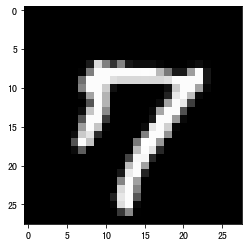

In [3]:
plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
print(Y_train[0])

In [4]:
class KDTreeNode:
    def __init__(self, data, label, split_dim, parent=None, left=None, right=None):
        self.data = data
        self.label = label
        self.split_dim = split_dim
        self.left = left
        self.right = right

class KHeap:
    def __init__(self, k):
        self.k = k
        self.data = []
        for i in range(k):
            self.data.append((-1, -1))
    
    def push(self, dist, label):
        for i in range(self.k):
            if (self.data[i][0] > dist) or (self.data[i][0] == -1):
                self.data.insert(i, (dist, label))
                break
        self.data = self.data[:self.k]
    
    def max_dist(self):
        return self.data[-1][0]
    
    def gen_label(self):
        labels = [x[1] for x in self.data]
        return max(labels, key=labels.count)

def build_KDTree(X, Y, depth=0):
    if len(X) == 0:
        return None
    dim = len(X[0])
    split_dim = depth % dim
    indices = np.argsort(X[:, split_dim])
    X = X[indices]
    Y = Y[indices]
    index = len(X) // 2
    left = build_KDTree(X[:index], Y[:index], depth+1)
    right = build_KDTree(X[index+1:], Y[index+1:], depth+1)
    node = KDTreeNode(data=X[index], label=Y[index], split_dim=split_dim, left=left, right=right)
    return node

def search_KDTree(node, p, heap):
    if node is None:
        return 
    
    dim = node.split_dim
    if p[dim] <= node.data[dim]:
        nxt = node.left
        oppo = node.right
    else:
        nxt = node.right
        oppo = node.left
    
    search_KDTree(nxt, p, heap)
    
    if (abs(p[dim] - node.data[dim]) < heap.max_dist()) or (heap.max_dist() == -1):
        search_KDTree(oppo, p, heap)
    
    dist = np.sum([(a - b) ** 2 for a, b in zip(node.data, p)])
    heap.push(dist, node.label)
        
class KNearestNeighbors:
    def __init__(self, kneighbors=5):
        self.kneighbors = kneighbors
        self.root = None
    
    def fit(self, X, Y):
        X = np.array(X)
        Y = np.array(Y)
        self.root = build_KDTree(X, Y)
    
    def predict(self, X):
        Y = []
        for x in X:
            heap = KHeap(self.kneighbors)
            search_KDTree(self.root, x, heap)
            Y.append(heap.gen_label())
        return Y

In [5]:
model = KNearestNeighbors(kneighbors=5)
model.fit(X_train, Y_train)
model.predict(X_val[:10])

[4, 1, 3, 5, 8, 7, 7, 8, 2, 7]

# sklearn

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [7]:
model = KNeighborsClassifier(algorithm='kd_tree')
model.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [8]:
Y_pred = model.predict(X_val)
accuracy_score(Y_val, Y_pred)

0.9661111111111111